# 3. Validation

In this notebook I do validation with the train dataset.

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_data_path = './data/train.csv'
train_dataframe = pd.read_csv(train_data_path)
train_dataframe.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
class Dataset:
    target_identifier = None
    def __init__(self, dataframe):
        self._dataframe = dataframe

    @property
    def is_trainable(self):
        if self.target_identifier in self._dataframe.columns:
            return True
        else:
            return False

    @property
    def features(self):
        if(self.is_trainable == True):
            return self._dataframe.drop(self.target_identifier, axis = 1).to_numpy()
        else:
            return self._dataframe.to_numpy()

    @property
    def targets(self):
        if(self.is_trainable == True):
            return self._dataframe[self.target_identifier].to_numpy()
        else:
            raise AttributeError("Test dataset does not contain targets.")

@pd.api.extensions.register_dataframe_accessor("dataset")
class Spaceship(Dataset):
    def __init__(self, dataframe):
        super().__init__(dataframe)
        self.target_identifier = 'Transported'
        
    def transported(self, status : bool = True):
        dataframe = self._dataframe
        return Spaceship(dataframe[dataframe[self.target_identifier] == status])

    def spender(self, status : bool = True):
        dataframe = self._dataframe
        if(status == True) :
            condition = (dataframe['CryoSleep'] == False) & (dataframe['Age'] > 12)
        else:
            condition = (dataframe['CryoSleep'] == True) | (dataframe['Age'] > 12)
        return dataframe[condition]

In [17]:
import sklearn

class CrossValidator:
    __cross_validation_method = None

    def __init__(self, model):
        self.__model = model
        self.__predictions = []
        self.__targets = []

    @classmethod
    def method(this, cross_validator):
        this.__cross_validation_method = cross_validator

    def fit(self, features, targets):
        X = features
        y = targets
        for train_index, test_index in self.__cross_validation_method.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.__model.fit(X_train, y_train)
            self.__targets.append(y_test)
            self.__predictions.append(self.__model.predict(X_test))

    @staticmethod
    def __concatenate_reports(predictions, targets):
        reports = [
            sklearn.metrics.classification_report(y_true, y_pred, output_dict = True)
            for y_true, y_pred in zip(targets, predictions) ]
        
        concatenated_reports = pd.concat([
            pd.DataFrame(report).transpose() for report in reports ])

        return concatenated_reports

    @property
    def mean(self):
        predictions = self.__predictions
        targets = self.__targets
        concatenated_reports = self.__concatenate_reports(predictions, targets)
        report_of_means = {}
        for index in concatenated_reports.index.unique():
            report_of_means[index] = concatenated_reports.loc[index].mean(axis = 0)
        return report_of_means
    
    @property
    def standard_deviation(self):
        predictions = self.__predictions
        targets = self.__targets
        concatenated_reports = self.__concatenate_reports(predictions, targets)
        report_of_standard_deviation = {}
        for index in concatenated_reports.index.unique():
            report_of_standard_deviation[index] = concatenated_reports.loc[index].std(axis = 0)
        return report_of_standard_deviation

In [18]:
dataframe = train_dataframe.copy()
df = dataframe.loc[:,["RoomService", "FoodCourt", "ShoppingMall", "VRDeck", "Spa", "Transported"]]
df = df.dropna(axis = 0)
dataset = df.dataset
validation_method = sklearn.model_selection.KFold(n_splits = 5, shuffle = True)

CrossValidator.method(validation_method)

means = []
standard_deviations = []
n_neighboors = np.arange(start = 5, stop = 300, step = 10)

for n in n_neighboors:
    validation = CrossValidator(sklearn.neighbors.KNeighborsClassifier(n))
    validation.fit(dataset.features, dataset.targets)
    mean = validation.mean
    means.append(validation.mean)
    standard_deviations.append(validation.standard_deviation)


In [20]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_validation(means, standard_deviations, label, ax):
    indices = mean.index
    ax.errorbar(x = indices, y = means, yerr = standard_deviations, label = label)

/tmp/ipykernel_786767/3012230986.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


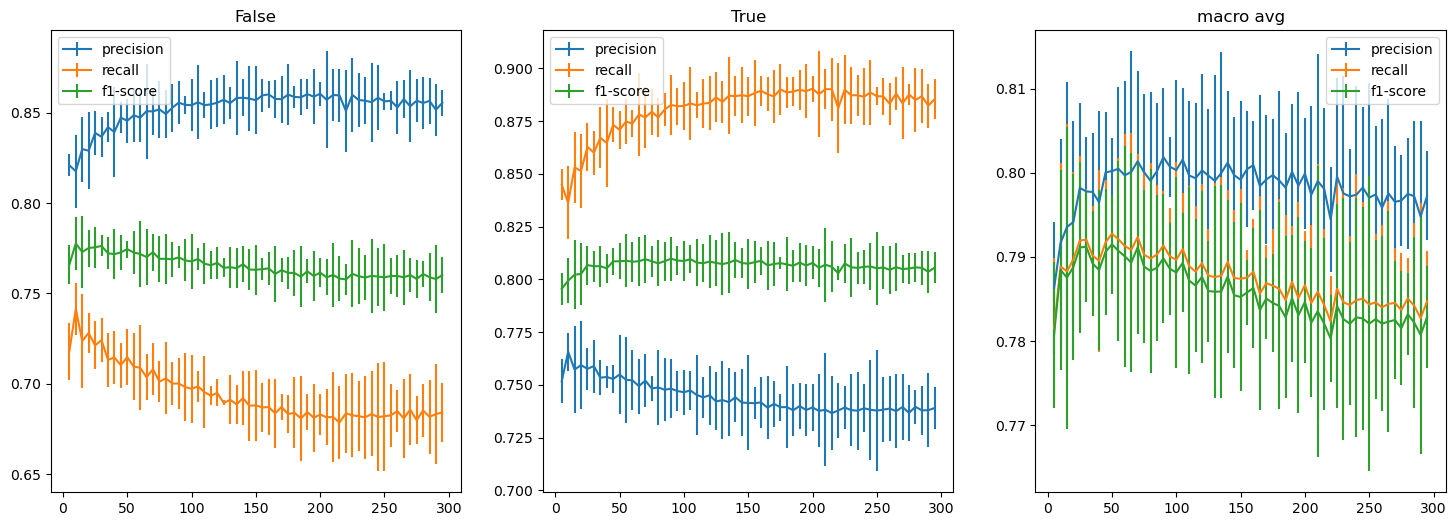

In [21]:
concatenated_means = pd.concat(
    [pd.DataFrame(report).transpose() for report in means ]).drop("support", axis = 1)

concatenated_std = pd.concat(
    [pd.DataFrame(report).transpose() for report in standard_deviations ]).drop("support", axis = 1)

keys = ["False", "True", "macro avg"]
indices = n_neighboors
figure = plt.figure(figsize = (18,6))

for index, key in enumerate(keys, start = 1):
    ax = figure.add_subplot(1,3,index)
    mean = concatenated_means.loc[key].copy()
    mean.index = indices
    std = concatenated_std.loc[key].copy()
    std.index = indices
    metrics = mean.columns
    for metric in metrics:
        plot_validation(mean[metric], std[metric], metric, ax)

    ax.legend()
    ax.set_title(key)

figure.show()